# SingleCell Data Analysis on the GPU
**Author:** [Severin Dicks](https://github.com/Intron7) (IBSM Freiburg)

To run this notebook please make sure you have a working rapids enviroment with all nessaray dependencies. Run the data_downloader notebook first to create the AnnData object we are working with. In this example workflow we'll be looking at a dataset of ca. 90000 cells from [Quin et al., Cell Research 2020](https://www.nature.com/articles/s41422-020-0355-0).

In [1]:
import numpy as np
import scanpy as sc
import anndata

import time
import os

import pandas as pd
import cudf
import cupy as cp

import sys
sys.path.append("../code/")

import scanpy_gpu_funcs as rsf
from cunnData import cunnData


import matplotlib.pyplot as plt
from matplotlib import rcParams

sc.set_figure_params(dpi= 100, dpi_save = 300)
rcParams['figure.figsize'] = 5,5




In [2]:
import rmm
rmm.reinitialize(
    managed_memory=True, # Allows oversubscription
    pool_allocator=False, # default is False
    devices=0, # GPU device IDs to register. By default registers only GPU 0.
)
cp.cuda.set_allocator(rmm.rmm_cupy_allocator)



## Load and Prepare Data

We load the sparse count matrix from an `h5ad` file using Scanpy. The sparse count matrix will then be placed on the GPU. 

In [3]:
data_load_start = time.time()

In [4]:
%%time
adata = sc.read("h5/adata.raw.h5ad")

CPU times: user 80 ms, sys: 112 ms, total: 192 ms
Wall time: 192 ms


In [5]:
adata.shape

(93575, 33694)

We now load the the AnnData object into a cunnData object. cunnData objects can be used as a replacement for scanpy and AnnData for the preprocessing. All functions are methods of the class.

In [6]:
%%time
cudata = cunnData(adata=adata)

CPU times: user 639 ms, sys: 422 ms, total: 1.06 s
Wall time: 1.07 s


Verify the shape of the resulting sparse matrix:

In [7]:
cudata.shape

(93575, 33694)

And the number of non-zero values in the matrix:

In [8]:
cudata.nnz

114212920

In [9]:
data_load_time = time.time()
print("Total data load and format time: %s" % (data_load_time-data_load_start))

Total data load and format time: 1.2946479320526123


## Preprocessing

In [10]:
preprocess_start = time.time()

### Quality Control

We perform a basic qulitiy control and plot the results

In [11]:
%%time
cudata.flag_gene_family(gene_family_name="MT", gene_family_prefix="MT")

CPU times: user 52.9 ms, sys: 1.52 ms, total: 54.4 ms
Wall time: 54.2 ms


In [12]:
%%time
cudata.flag_gene_family(gene_family_name="RIBO", gene_family_prefix="RPS")

CPU times: user 1.06 ms, sys: 0 ns, total: 1.06 ms
Wall time: 778 µs


In [13]:
%%time
cudata.caluclate_qc(qc_vars=["MT","RIBO"])

CPU times: user 320 ms, sys: 166 ms, total: 486 ms
Wall time: 486 ms


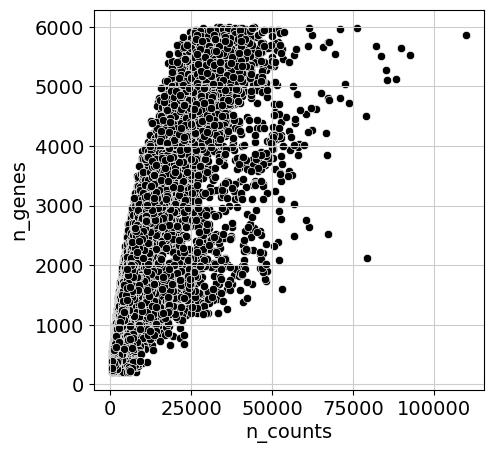

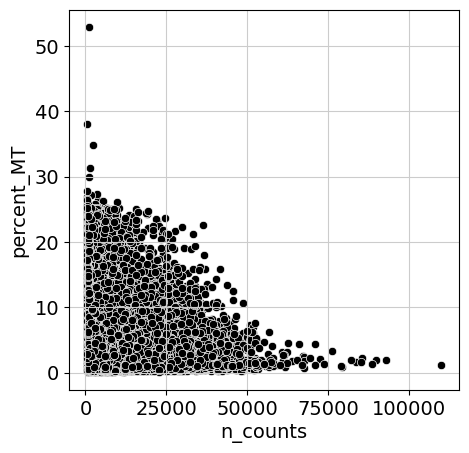

In [14]:
rsf.plt_scatter(cudata,"n_counts","n_genes")
rsf.plt_scatter(cudata,"n_counts","percent_MT")

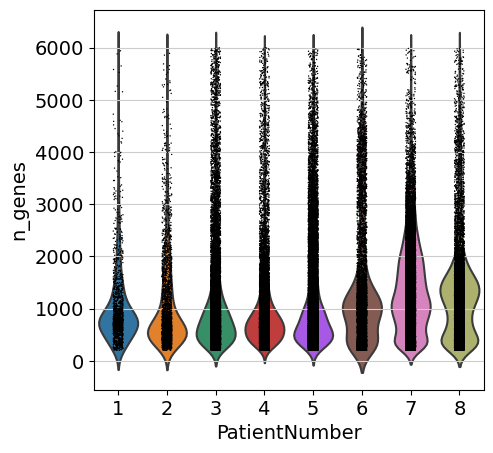

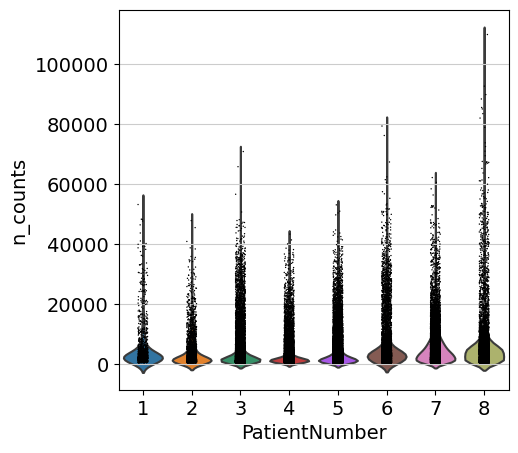

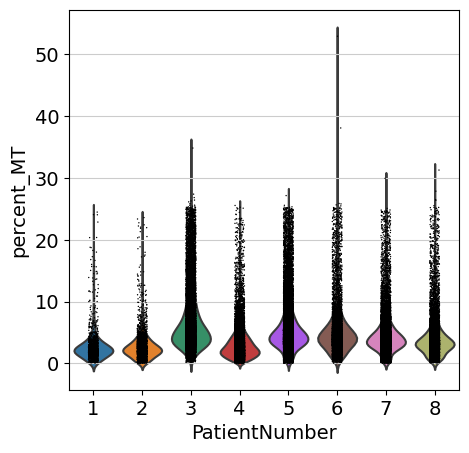

In [15]:
rsf.plt_violin(cudata,key="n_genes",group_by="PatientNumber")
rsf.plt_violin(cudata,key="n_counts",group_by="PatientNumber")
rsf.plt_violin(cudata,key="percent_MT",group_by="PatientNumber")

### Filter

We filter the count matrix to remove cells with an extreme number of genes expressed.
We also filter out cells with a mitchondrial countent of more than 20%.

The size of our count matrix is now reduced.

In [16]:
%%time
cudata.filter_cells(qc_var='n_genes',max_count =5000)
cudata.filter_cells(qc_var='percent_MT',max_count=20)

filtered out 909 cells
filtered out 1598 cells
CPU times: user 152 ms, sys: 76.9 ms, total: 229 ms
Wall time: 228 ms


We also filter out genes that are expressed in less than 3 cells.

In [17]:
%%time
cudata.filter_genes(min_cells=3)

filtered out 8331 genes that are detected in less than 3 cells
CPU times: user 292 ms, sys: 157 ms, total: 449 ms
Wall time: 448 ms


In [18]:
cudata.shape

(91068, 25363)

### Normalize

We normalize the count matrix so that the total counts in each cell sum to 1e4.

In [19]:
%%time
cudata.normalize_total(target_sum=1e4)

CPU times: user 624 µs, sys: 0 ns, total: 624 µs
Wall time: 495 µs


Next, we log transform the count matrix.

In [20]:
%%time
cudata.log1p()

CPU times: user 58.4 ms, sys: 23.4 ms, total: 81.8 ms
Wall time: 81.3 ms


### Select Most Variable Genes

Now we search for highly variable genes. This function only supports the flavors `cell_ranger` `seurat`. As you can in scanpy you can filter based on cutoffs or select the top n cells. You can also use a `batch_key` to reduce batcheffects. 

In [21]:
%%time
cudata.highly_varible_genes(batch_key = "PatientNumber")

CPU times: user 1.04 s, sys: 153 ms, total: 1.2 s
Wall time: 1.2 s


Now we safe this verion of the cunndata object as an AnnData one. We'll use this as adata.raw later. 

In [22]:
%%time
bdata = cudata.to_AnnData()

CPU times: user 127 ms, sys: 35 ms, total: 162 ms
Wall time: 161 ms


Now we restrict our cunndata object to the highly variable genes.

In [23]:
%%time
cudata.filter_highly_variable()

CPU times: user 123 ms, sys: 90.6 ms, total: 214 ms
Wall time: 209 ms


In [24]:
cudata.shape

(91068, 2467)

Next we regess out effects of counts per cell and the mitochondrial content of the cells. As you can with scanpy you can use every numerical column in `.obs` for this.

In [25]:
%%time
cudata.regress_out(keys=["n_counts", "percent_MT"])

CPU times: user 12.9 s, sys: 3.79 s, total: 16.6 s
Wall time: 16.7 s


### Scale

Finally, we scale the count matrix to obtain a z-score and apply a cutoff value of 10 standard deviations.

In [26]:
%%time
cudata.scale(max_value=10)

CPU times: user 136 ms, sys: 24.2 ms, total: 160 ms
Wall time: 160 ms


Next we transfrom our cunnData object back to an AnnData object. We also set the normalized and logarithmized raw gene expression from bdata as adata.raw.

In [27]:
%%time
adata = cudata.to_AnnData()
adata.raw = bdata
del bdata

CPU times: user 172 ms, sys: 55.1 ms, total: 227 ms
Wall time: 226 ms


In [28]:
preprocess_time = time.time()
print("Total Preprocessing time: %s" % (preprocess_time-preprocess_start))

Total Preprocessing time: 21.517083406448364


We have now finished the preprocessing of the data.

## Clustering and Visulization

### Principal component analysis

We use PCA to reduce the dimensionality of the matrix to its top 100 principal components. We use the PCA implementation from `scanpy_gpu_funcs` that uses cuMLs PCA to run this.

In [29]:
%%time
rsf.pca(adata, n_comps = 100)

CPU times: user 492 ms, sys: 273 ms, total: 765 ms
Wall time: 765 ms


We can use scanpy `pca_variance_ratio` plot to inspect the contribution of single PCs to the total variance in the data.

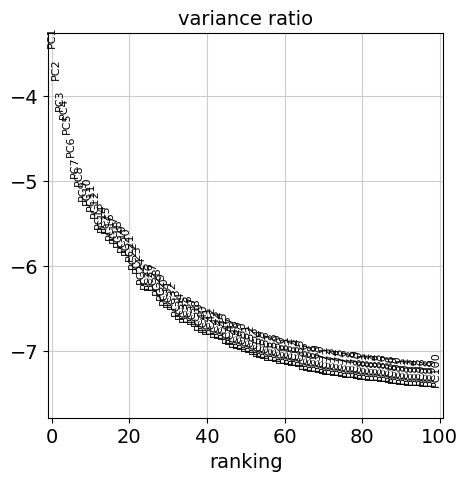

In [30]:
sc.pl.pca_variance_ratio(adata, log=True,n_pcs=100)

### Computing the neighborhood graph and UMAP

Next we compute the neighborhood graph using scanpy. Scanpy allready has so built in functions for GPU computing with rapids (`pp.neighbors`, `tl.umap` and `tl.louvain`). For `pp.neighbors` and `tl.umap` GPU computing can be invoked with `method='rapids'`.

Scanpy CPU implementation of nearest neighbor uses an approximation, while the GPU version calculates the excat graph. Both methods are valid, but you might see differences.

In [31]:
%%time
sc.pp.neighbors(adata, n_neighbors=15, n_pcs=20, method='rapids')

CPU times: user 6.57 s, sys: 124 ms, total: 6.7 s
Wall time: 6.69 s


Next we calculate the UMAP embedding using rapdis within scanpy.

In [32]:
%%time
sc.tl.umap(adata, method='rapids')

CPU times: user 3.02 s, sys: 2.24 s, total: 5.26 s
Wall time: 5.24 s


### Clustering

Next, we use the Louvain and Leiden algorithm for graph-based clustering. As of the time of writing this notebook there is a known small bug in scanpy. The resoltion parameter of Louvain is not correctly passed to the cugraph funciton. This results in the resoltion beeing looked at 1.0.
Since the bug is fixed you can use `scanpy_gpu_funcs` implementation of Louvain.
Leiden clustering using Rapids has not been implemented in scanpy. You can also use `scanpy_gpu_funcs` implementation of the Leiden algorithm.

In [33]:
%%time
rsf.louvain(adata)
#sc.tl.louvain(adata,flavor="rapids")

CPU times: user 434 ms, sys: 18.9 ms, total: 453 ms
Wall time: 452 ms


In [34]:
%%time
rsf.leiden(adata)

CPU times: user 545 ms, sys: 11.2 ms, total: 556 ms
Wall time: 554 ms


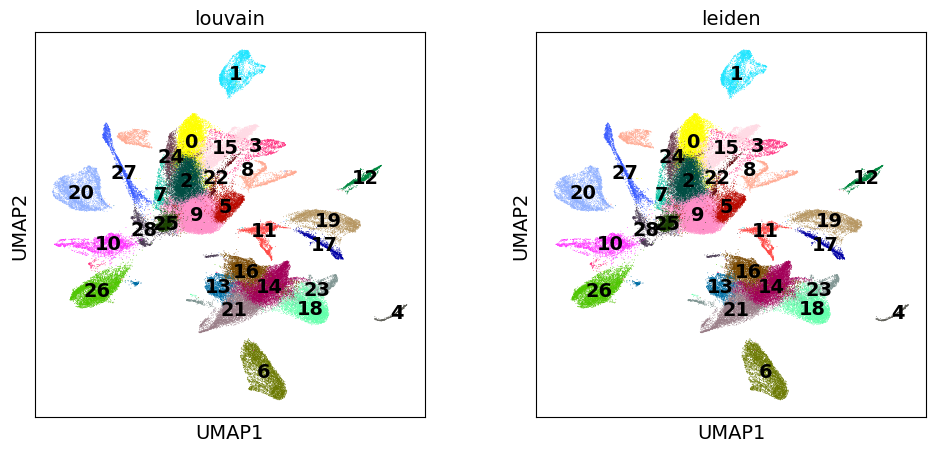

CPU times: user 549 ms, sys: 5.11 ms, total: 555 ms
Wall time: 554 ms


In [35]:
%%time
sc.pl.umap(adata, color=["louvain","leiden"],legend_loc = 'on data')

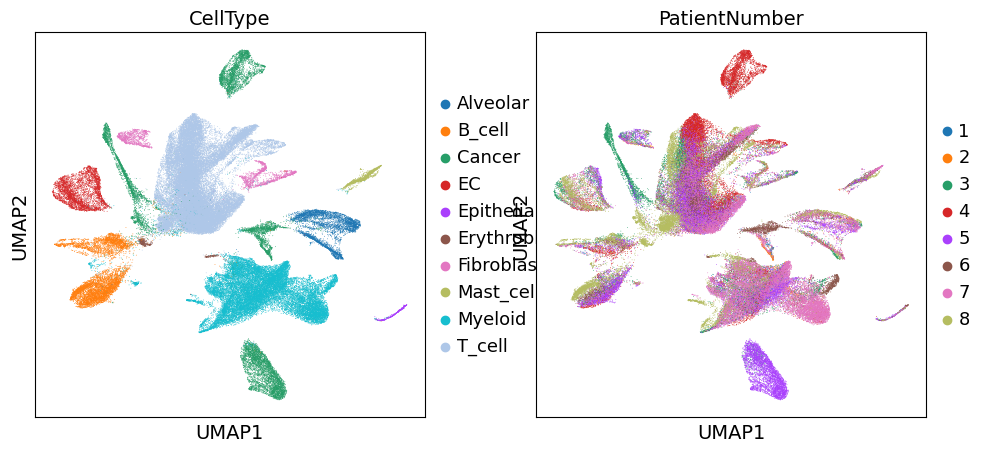

In [36]:
sc.pl.umap(adata, color= ["CellType", "PatientNumber"])

### TSNE + k-Means

Next we use TSNE on the GPU to visualize the cells in two dimensions. We also perform k-Means clustering of the cells into 8 clusters.

In [37]:
%%time
rsf.tsne(adata, n_pcs = 40,perplexity=30,early_exaggeration=12, learning_rate=200)

[W] [17:01:26.155353] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...
CPU times: user 1.19 s, sys: 831 ms, total: 2.02 s
Wall time: 2.01 s


In [38]:
rsf.kmeans(adata, n_clusters=8)

... storing 'kmeans' as categorical


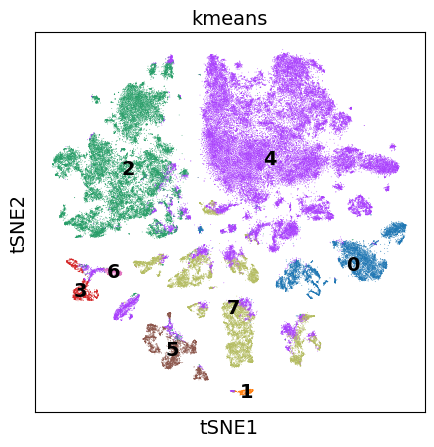

CPU times: user 285 ms, sys: 0 ns, total: 285 ms
Wall time: 285 ms


In [39]:
%%time
sc.pl.tsne(adata, color=["kmeans"],legend_loc = 'on data')

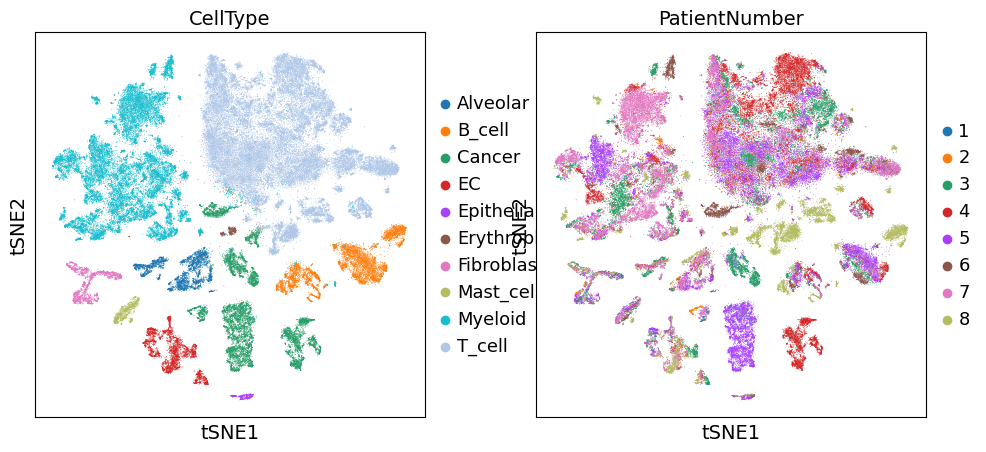

In [40]:
sc.pl.tsne(adata, color= ["CellType", "PatientNumber"])

## Differential expression analysis

We now use logistic regression to compute a ranking for highly differential genes in each Louvain cluster.

In [41]:
sparse_gpu_array = cp.asarray(adata.X)
cluster_labels = cudf.Series(adata.obs["louvain"]).reset_index(drop="True")
genes = cudf.Series(adata.var_names)

We use logistic regression to identify the top 50 genes distinguishing each cluster.

In [42]:
%%time
scores, names, reference = rsf.rank_genes_groups(
    sparse_gpu_array, 
    cluster_labels, 
    genes, 
    n_genes=sparse_gpu_array.shape[1], groups='all', reference='rest')

[W] [17:01:33.052707] L-BFGS: max iterations reached
[W] [17:01:33.053204] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.
Ranking took (GPU): 3.8768868446350098
Preparing output np.rec.fromarrays took (CPU): 0.005596160888671875
Note: This operation will be accelerated in a future version
CPU times: user 3.73 s, sys: 181 ms, total: 3.91 s
Wall time: 3.91 s


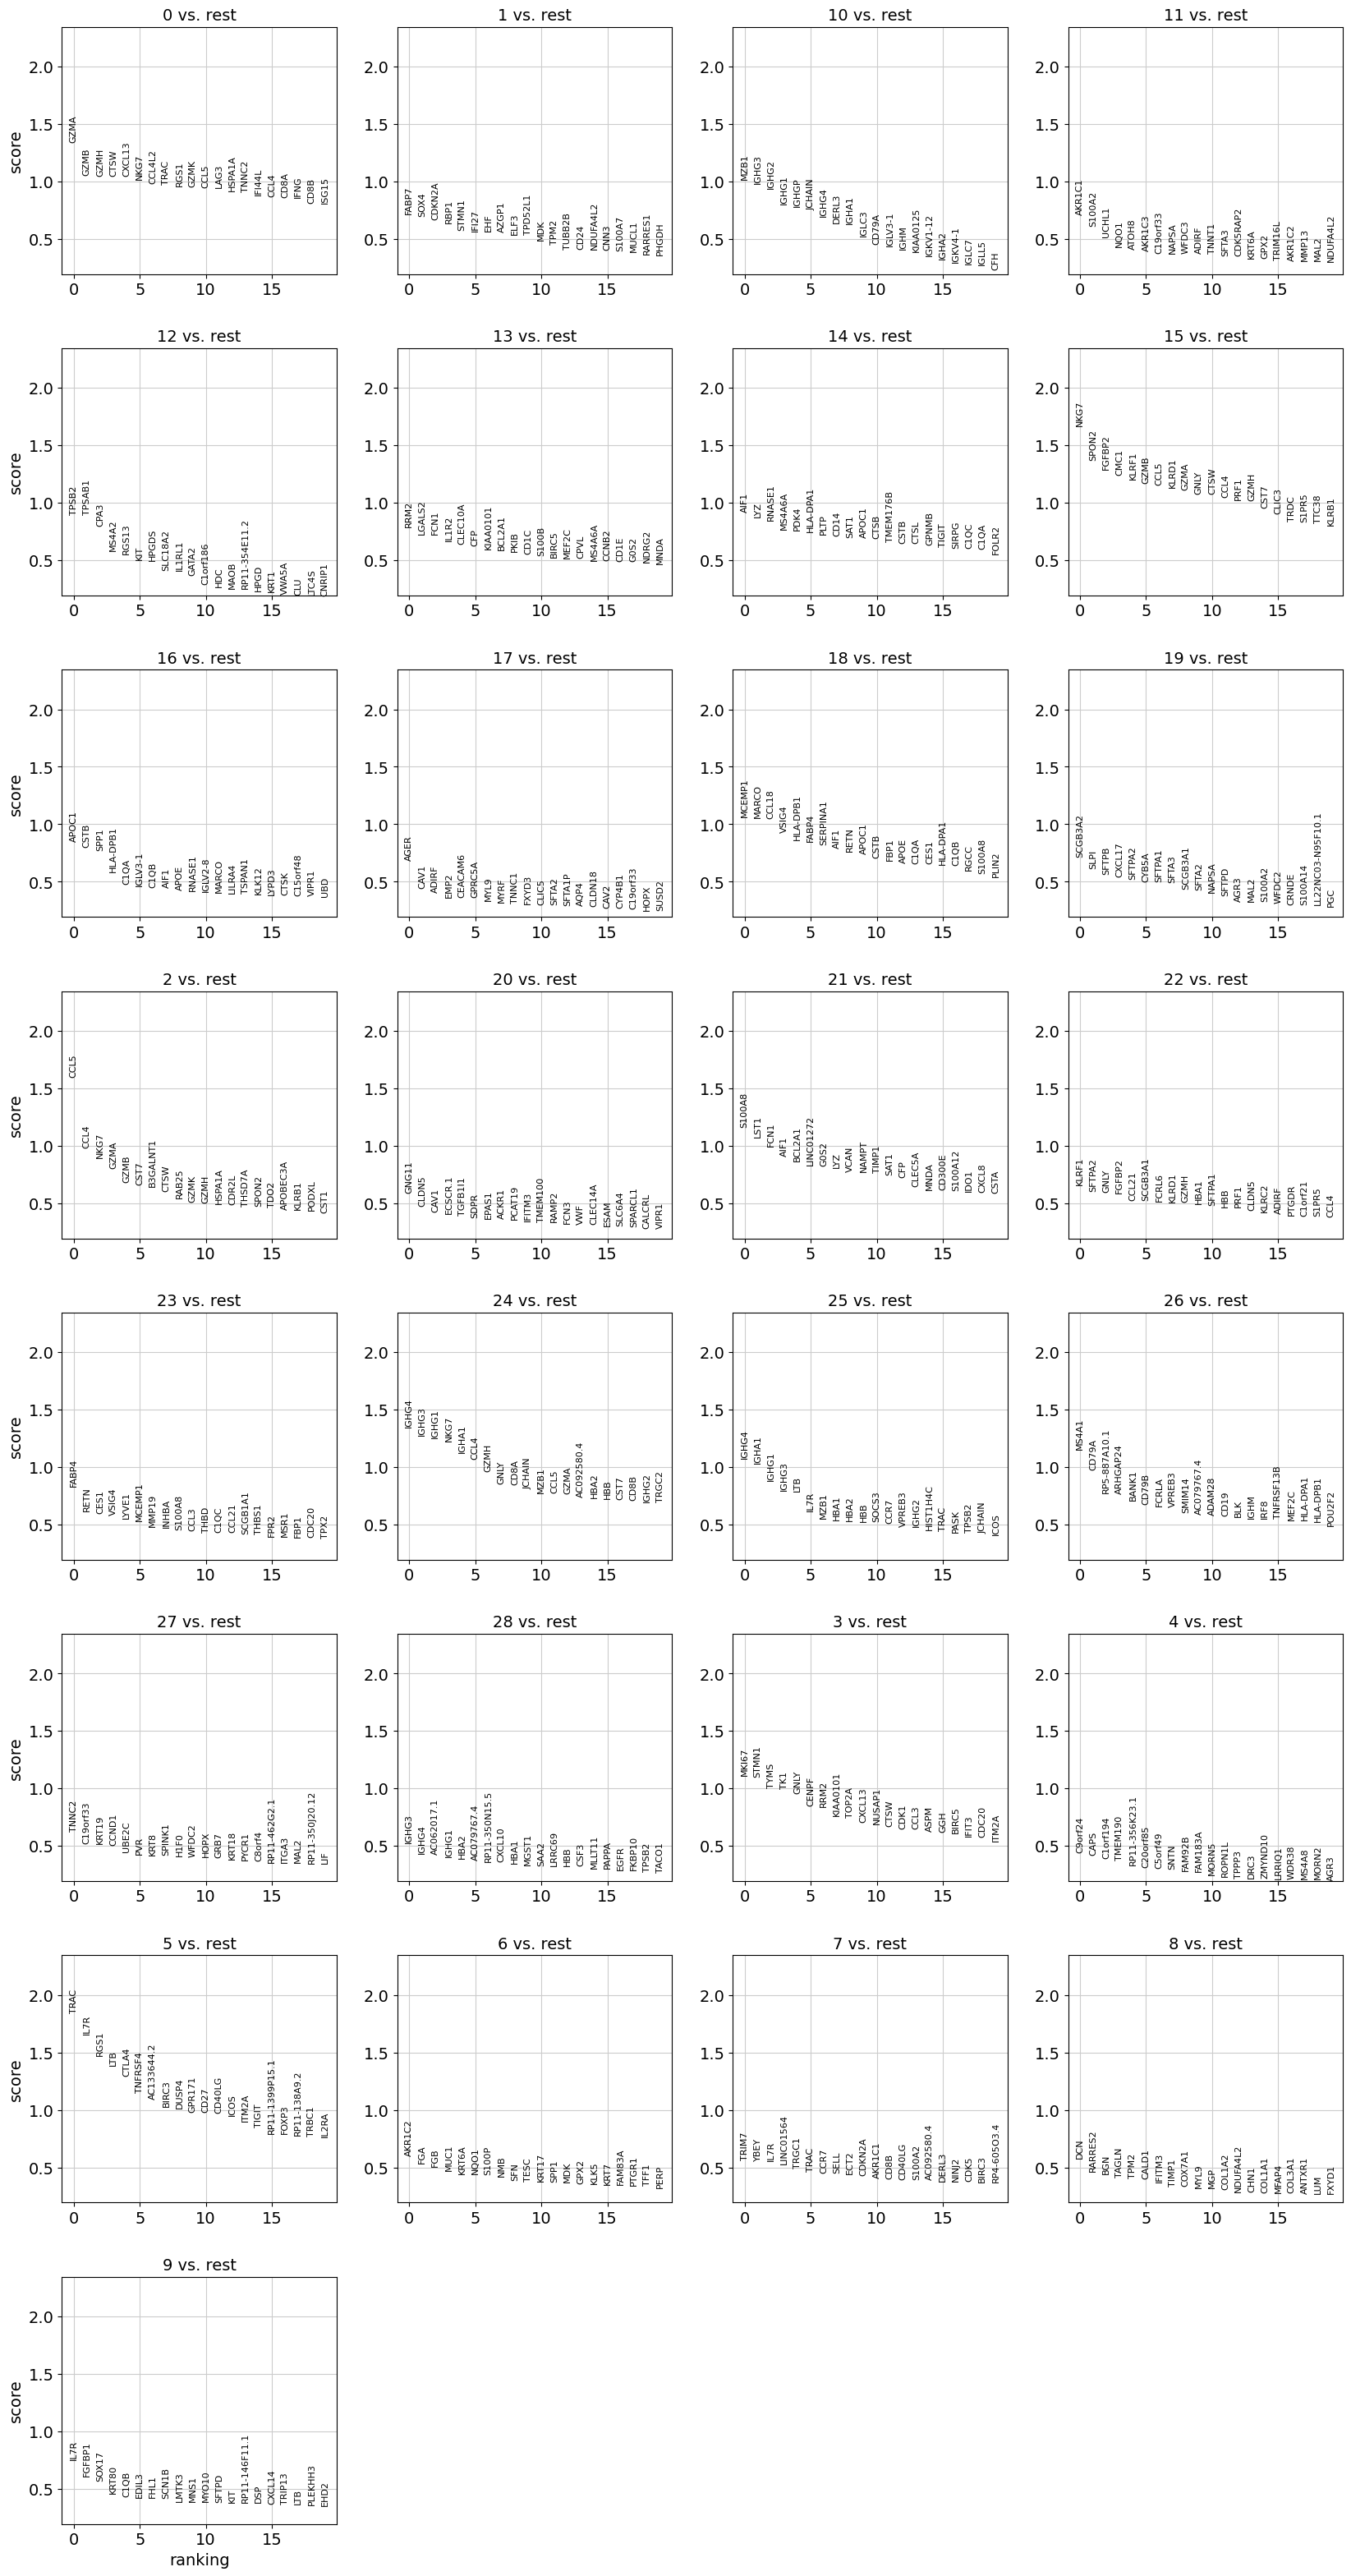

CPU times: user 1.92 s, sys: 42.4 ms, total: 1.96 s
Wall time: 1.96 s


In [43]:
%%time
adata.uns["rank_genes_groups"] = {}
adata.uns["rank_genes_groups"]["params"] = dict(groupby="louvain", method="logreg", reference=reference, use_raw=False)
adata.uns["rank_genes_groups"]['scores'] = scores
adata.uns["rank_genes_groups"]['names'] = names
sc.pl.rank_genes_groups(adata, n_genes=20)

In [44]:
post_time = time.time()

In [45]:
print("Total Postprocessing time: %s" % (post_time-preprocess_time))

Total Postprocessing time: 24.163222074508667


## Diffusion Maps

With cupy 9 its possible to compute Eigenvalues of sparse matrixes. We now create a Diffusion Map of the T-Cells to look at trajectories.

First we create a subset of only the T-Cells

In [46]:
tdata = adata[adata.obs["CellType"] == 'T_cell',:]

We can repeat the dimension reduction, clustering and visulatization.

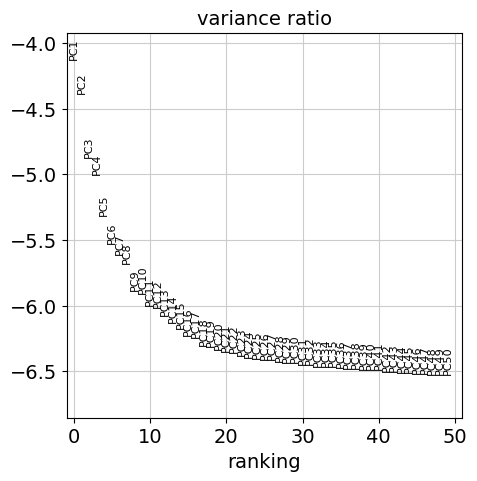

CPU times: user 460 ms, sys: 132 ms, total: 592 ms
Wall time: 591 ms


In [47]:
%%time
rsf.pca(tdata,n_comps=50)
sc.pl.pca_variance_ratio(tdata, log=True,n_pcs=50)

In [48]:
%%time
sc.pp.neighbors(tdata, n_neighbors=15, n_pcs=20, method='rapids')
sc.tl.umap(tdata, method='rapids')
rsf.louvain(tdata)

CPU times: user 1.95 s, sys: 907 ms, total: 2.86 s
Wall time: 2.85 s


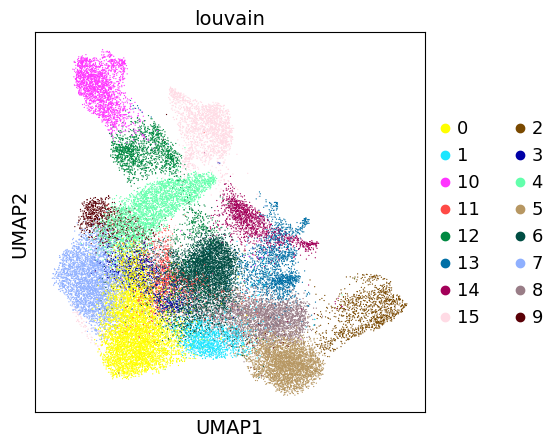

In [49]:
sc.pl.umap(tdata, color=["louvain"])

As stated before Diffusion Maps have become an integral part of single cell analysis. To run the computation with cupy 9, you can use `scanpy_gpu_funcs` implementation.

In [50]:
%%time
rsf.diffmap(tdata)

CPU times: user 723 ms, sys: 1.46 s, total: 2.19 s
Wall time: 328 ms


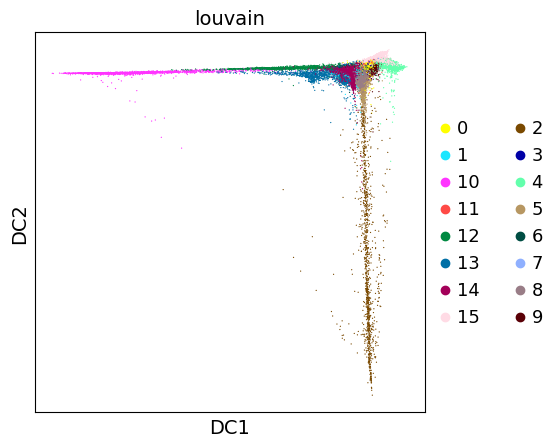

In [51]:
sc.pl.diffmap(tdata, color='louvain')

After this you can use `X_diffmap` for `sc.pp.neighbors` and other fuctions. 

In [52]:
print("Total Preprocessing time: %s" % (time.time()-preprocess_start))

Total Preprocessing time: 50.151209115982056
